# Clasificación de Push-Ups 

## Extracción de los puntos clave de los vídeos
Utilizamos la librería Media Pipe para la extracción de las coordenadas de los puntos clave del cuerpo en el vídeo.

In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os

mp_pose = mp.solutions.pose # Modelo de detección de pose de MediaPipe que detecta 33 puntos del cuerpo humano 

def extract_xy_sequence(video_path,
                        min_detect=0.5, # confianza mínima para detección 
                        min_track=0.5, # confianza mínima para seguimiento
                        model_complexity=1): # complejidad del modelo (0,1,2), mayor = más preciso pero más lento
    
    """
    Extrae la secuencia de 33 puntos clave (landmarks) del cuerpo
    en coordenadas (x, y) normalizadas para cada frame del vídeo.

    Devuelve:
        sequence → array de forma (num_frames, 33, 2)
    """
    

    sequence = []   # Lista donde almacenaremos los landmarks de cada frame

    # Abrimos el archivo de vídeo para poder leer frame por frame
    cap = cv2.VideoCapture(video_path)

    with mp_pose.Pose( 
        static_image_mode=False, 
        model_complexity=model_complexity, 
        min_detection_confidence=min_detect,
        min_tracking_confidence=min_track 
    ) as pose:
        """
        Crea un objeto "pose" que se encarga de detectar la pose humana, que procesará cada frame y extraerá los landmarks
        en cada imagen. Está configurado para:
          - static_image_mode=False → optimiza para vídeo (tracking)
          - model_complexity → control de precisión/velocidad
          - min_detection_confidence → confianza mínima para detectar (umbral mínimo para detectar correctamente una persona )
          - min_tracking_confidence → confianza mínima para mantener seguimiento (umbral mínimo para seguirla en movimiento)
        """

        while True:
            ret, frame = cap.read()
            # ret: indica si se pudo leer el frame
            # frame: imagen del frame actual

            if not ret:
                break   # Salimos si se terminó el vídeo

            # OpenCV usa BGR; MediaPipe necesita RGB
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Procesa el frame para detectar la pose 
            results = pose.process(img)
            # El objeto que devuelve contiene los 33 puntos del cuerpo, cada uno con: 
                        # (x, y) coordenanadas normalizadas (0-1, relativas al tamaño del frame)
                        # z: profundidad relativa 
                        # visibility: probabilidad de que el punto sea visible

            # Si se detectaron landmarks de la pose
            if results.pose_landmarks:
                # extraemos 33 puntos: x,y
                pts = [] # Lista donde almacenaremos los 33 puntos (x,y) del frame actual

                # Pero solo nos interesa x,y
                for lm in results.pose_landmarks.landmark:
                    pts.extend([lm.x, lm.y])  # <-- SOLO x,y 

                pts = np.array(pts)    # 33*2 = 66 elementos

            else:
                # si no detecta → rellenar con ceros
                pts = np.zeros(66)
                print(f"Warning: No se detectaron landmarks en un frame de {video_path}")

            sequence.append(pts)

    cap.release() # Cerramos el vídeo
    sequence = np.array(sequence) # (num_frames, 66) las columnas tienen la forma: [x0, y0, x1, y1, x2, y2, ..., x32, y32]
    return sequence


In [3]:
def draw_landmarks_on_frame(frame, landmarks, connections=None, point_color=(0,0,255), line_color=(0,255,0), radius=3, thickness=2, skip_zeros=True):
    """
    Dibuja los landmarks sobre un frame (imagen en BGR).

    Args:
        frame (np.ndarray): imagen BGR donde dibujar (modificada in-place).
        landmarks: array shape (66,) o (num_landmarks, 2) con coordenadas normalizadas (x, y).
                   Puede ser también (num_landmarks*2,) aplanado.
        connections: iterable de pares (a, b) indicando conexiones entre landmarks. Si None,
                     se intentará usar mp_pose.POSE_CONNECTIONS si MediaPipe está importado.
        point_color, line_color: colores BGR para puntos y líneas.
        radius, thickness: tamaño del punto y grosor de línea.
        skip_zeros: si True, no dibuja puntos con coordenadas exactamente (0,0).

    Returns:
        frame con los dibujos (la misma referencia modificada).
    """
    import numpy as np
    h, w = frame.shape[:2]

    arr = np.asarray(landmarks)
    if arr.ndim == 1:
        # Aseguramos que tenga forma (n_landmarks, 2)
        if arr.size % 2 != 0:
            raise ValueError("El array de landmarks debe tener un número par de elementos (x,y pairs).")
        arr = arr.reshape(-1, 2)

    # Intentamos usar conexiones de MediaPipe si no se pasan
    if connections is None:
        try:
            connections = mp_pose.POSE_CONNECTIONS
        except Exception:
            connections = []

    # Dibujar puntos
    for (x, y) in arr:
        # x, y están normalizados respecto al ancho/alto
        if skip_zeros and x == 0 and y == 0:
            continue
        cx = int(round(x * w))
        cy = int(round(y * h))
        # Evitamos dibujar fuera del frame
        if cx < 0 or cy < 0 or cx >= w or cy >= h:
            continue
        cv2.circle(frame, (cx, cy), radius, point_color, -1)

    # Dibujar conexiones
    for a, b in connections:
        if a >= arr.shape[0] or b >= arr.shape[0]:
            continue
        x1, y1 = arr[a]
        x2, y2 = arr[b]
        if skip_zeros and ((x1 == 0 and y1 == 0) or (x2 == 0 and y2 == 0)):
            continue
        p1 = (int(round(x1 * w)), int(round(y1 * h)))
        p2 = (int(round(x2 * w)), int(round(y2 * h)))
        # Evitamos líneas parcialmente fuera de imagen
        cv2.line(frame, p1, p2, line_color, thickness)

    return frame


In [4]:
def extract_frame_from_video(video_path, frame_idx=None, time_sec=None, as_bgr=True):
    """
    Extrae un único frame de un vídeo.

    Parámetros:
      - video_path (str): ruta al archivo de vídeo.
      - frame_idx (int, opcional): índice del frame (0-based). Si se proporciona, se usa.
      - time_sec (float, opcional): tiempo en segundos para extraer el frame. Si se proporciona y
        frame_idx es None, se usará time_sec.
      - as_bgr (bool): si True devuelve la imagen en BGR (formato OpenCV). Si False devuelve RGB.

    Devuelve:
      - frame (np.ndarray) o None si no se pudo leer.

    Notas:
      - Si ni frame_idx ni time_sec se pasan, se devolverá el primer frame (índice 0).
      - La función maneja bounds y verifica que el índice o tiempo esté en el rango del vídeo.
    """
    import cv2
    import numpy as np

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"No se pudo abrir el vídeo: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

    # Determinar el frame objetivo
    target_idx = 0
    if frame_idx is not None:
        if frame_idx < 0:
            raise ValueError("frame_idx debe ser >= 0")
        # clamp
        if total_frames > 0:
            target_idx = min(frame_idx, total_frames - 1)
        else:
            target_idx = frame_idx
    elif time_sec is not None:
        if time_sec < 0:
            raise ValueError("time_sec debe ser >= 0")
        if fps > 0:
            target_idx = int(round(time_sec * fps))
            if total_frames > 0:
                target_idx = min(target_idx, total_frames - 1)
        else:
            # si FPS desconocido, fallback a 0
            target_idx = 0
    else:
        target_idx = 0

    # Posicionar y leer
    cap.set(cv2.CAP_PROP_POS_FRAMES, target_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        return None

    if not as_bgr:
        # convertir a RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame


# Ejemplos de uso:
# 1) Extraer por índice:
frame10 = extract_frame_from_video('../Dataset/Correct sequence/Copy of push up 4.mp4', frame_idx=10)
# 2) Extraer por tiempo (segundos):
# frame_at_2s = extract_frame_from_video('ruta/video.mp4', time_sec=2.0)
# 3) Obtener en RGB para visualizar con matplotlib:
# frame_rgb = extract_frame_from_video('ruta/video.mp4', frame_idx=0, as_bgr=False)


In [5]:
import os
# Ejemplo de uso
data_path = "../Dataset"
correct_push_ups_path = os.path.join(data_path, "Correct sequence")
wrong_push_ups_path = os.path.join(data_path, "Wrong sequence")
example_video_path = os.path.join(correct_push_ups_path, "Copy of push up 4.mp4")
seq = extract_xy_sequence(example_video_path)
print(seq.shape)    # → (num_frames, 33, 2)
print(type(seq))          # array con las coordenadas (x,y) de los 33 landmarks por frame


I0000 00:00:1763031767.174437  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763031767.253747  735181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763031767.262803  735182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/exml-py310/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


(57, 66)
<class 'numpy.ndarray'>


(-0.5, 639.5, 359.5, -0.5)

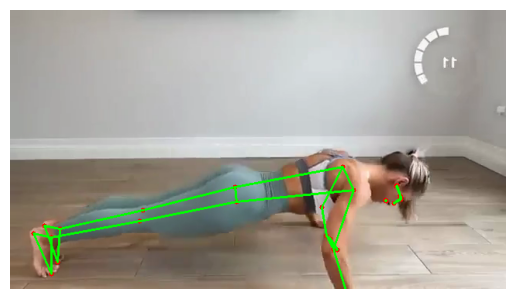

In [6]:
# Ejemplo de uso (comentado):
#frame = cv2.imread('ruta_a_imagen.jpg')  # BGR
frame = extract_frame_from_video('../Dataset/Correct sequence/Copy of push up 4.mp4', frame_idx=10)
lm = seq[10]  # si seq tiene shape (num_frames, 66) o (num_frames, 33, 2)
draw_landmarks_on_frame(frame, lm)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')


In [7]:
# Probamos a añadir padding a la secuencia de ejemplo
PADDING_LENGTH = 150  # longitud máxima de secuencia (frames)

padding_needed = PADDING_LENGTH - seq.shape[0] # cuántos frames de padding hacen falta
padding_array = np.zeros((padding_needed, 66))

seq_padded = np.vstack((seq, padding_array))
print(seq_padded.shape)  # → (150, 66)

(150, 66)


In [8]:
# Extraemos todos los landmarks de los vídeos de flexiones
correct_push_ups_videos = os.listdir(correct_push_ups_path) 
wrong_push_ups_videos = os.listdir(wrong_push_ups_path)

# Listas donde almacenaremos las secuencias de landmarks de cada vídeo
correct_push_ups_data = []
wrong_push_ups_data = []

for video_file in correct_push_ups_videos:
    video_path =  os.path.join(correct_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    correct_push_ups_data.append(seq)

for video_file in wrong_push_ups_videos:
    video_path =  os.path.join(wrong_push_ups_path, video_file)
    seq = extract_xy_sequence(video_path)

    wrong_push_ups_data.append(seq)

lengths_correct = np.array(list(map(lambda x: x.shape, correct_push_ups_data)))
lengths_wrong = np.array(list(map(lambda x: x.shape, wrong_push_ups_data)))

I0000 00:00:1763031768.876085  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763031768.948065  735228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763031768.954100  735228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763031770.262833  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763031770.332820  735264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763031770.338804  735264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763031771.684986  734355 gl

I0000 00:00:1763031919.092851  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763031919.161493  738126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763031919.167942  738126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763031920.960916  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763031921.029432  738186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763031921.035584  738186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763031922.718617  734355 gl

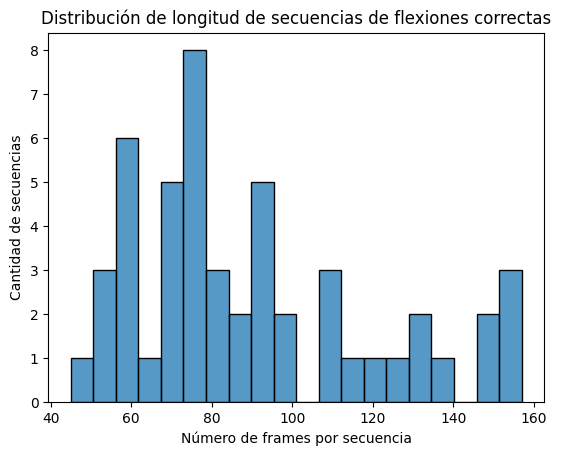

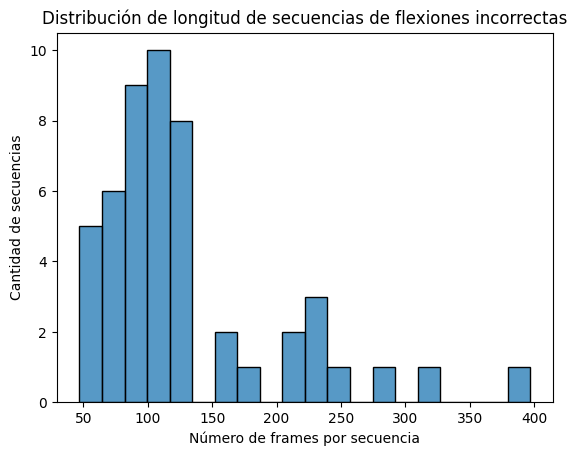

In [10]:
# Graficamos la distribución de número de frames por secuencia
import matplotlib.pyplot as plt 
import seaborn as sns

sns.histplot([l[0] for l in lengths_correct], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones correctas")
plt.show()

sns.histplot([l[0] for l in lengths_wrong], bins=20)
plt.xlabel("Número de frames por secuencia")
plt.ylabel("Cantidad de secuencias")
plt.title("Distribución de longitud de secuencias de flexiones incorrectas")
plt.show()


Podemos observar que la gran mayoría de vídeos no tiene más de 200 frames. Por ende, sería conveniente añadirle un padding de 0s a los que tenga menos frames y truncar aquellos que superen esa cantidad.

In [11]:
import os
import numpy as np

def load_landmark_sequences_from_folder(folder_path, padding_length=200):
    """
    Procesa todos los videos de una carpeta y devuelve un array
    de secuencias de landmarks con shape (n_videos, padding_length, 66).

    Args:
        folder_path (str): ruta a la carpeta con vídeos
        padding_length (int): nº máximo de frames para pad/recorte

    Returns:
        np.ndarray: array final con shape (n_videos, padding_length, 66)
    """

    videos = os.listdir(folder_path)
    sequences = []

    for video_name in videos:
        video_path = os.path.join(folder_path, video_name)

        # Extraemos coordenadas (num_frames, 33, 2)
        seq = extract_xy_sequence(video_path)

        # Aplanamos por frame → (num_frames, 66)
        seq = seq.reshape(seq.shape[0], -1)

        # === Padding o recorte ===
        n_frames = seq.shape[0]

        if n_frames < padding_length:
            # Padding con ceros
            padding_needed = padding_length - n_frames
            padding = np.zeros((padding_needed, 66))
            seq_padded = np.vstack((seq, padding))

        elif n_frames > padding_length:
            # Recorte
            seq_padded = seq[:padding_length, :]

        else:
            seq_padded = seq

        # Añadimos al dataset
        sequences.append(seq_padded)

    # Convertimos lista → numpy array 3D
    return np.array(sequences)


Para ver cuanto padding añadir, vamos a calcular el percentil 90

In [ ]:
import math

frames_videos_correctos = lengths_correct[:, 0]
frames_videos_incorrectos = lengths_wrong[:, 0]

# Concatenamos
longitudes_de_secuencia = np.concatenate([frames_videos_correctos, frames_videos_incorrectos])

# Calculamos el valor L_opt con percentil 90 y redondeamos al entero superior más cercano (ceil)
percentil_de_corte = 90
L_opt_flotante = np.percentile(longitudes_de_secuencia, percentil_de_corte)
L_opt = math.ceil(L_opt_flotante)

print(f"El valor L_opt sugerido es: {L_opt} frames")

El valor L_opt sugerido es: 160 frames


In [28]:
# Procesamos todos los landmarks de los vídeos de flexiones en ambas carpetas
PADDING_LENGTH = 160  # longitud máxima de secuencia (frames)

correct_push_ups_data = load_landmark_sequences_from_folder(correct_push_ups_path, padding_length=PADDING_LENGTH)
wrong_push_ups_data   = load_landmark_sequences_from_folder(wrong_push_ups_path,   padding_length=PADDING_LENGTH)

print("Forma de los landmarks arrays de los vídeos de flexiones correctas:", correct_push_ups_data.shape)  # (n_videos, 160, 66)
print("Forma de los landmarks arrays de los vídeos de flexiones incorrectas:", wrong_push_ups_data.shape)  # (n_videos, 160, 66)

I0000 00:00:1763033991.241979  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763033991.335995  771619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763033991.342878  771619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/miniconda3/envs/exml-py310/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
I0000 00:00:1763033992.672948  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763033992.744524  771671 inference_feedback_manager.cc:1

I0000 00:00:1763034143.223823  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763034143.292443  775080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763034143.298741  775080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763034145.102963  734355 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1763034145.171482  775130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763034145.177631  775136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1763034146.870844  734355 gl

Forma de los landmarks arrays de los vídeos de flexiones correctas: (50, 160, 66)
Forma de los landmarks arrays de los vídeos de flexiones incorrectas: (50, 160, 66)


In [29]:
# Almacenamos en discos los arrays procesados
np.save("../Data/Processed/correct_push_ups_landmarks.npy", correct_push_ups_data)
np.save("../Data/Processed/wrong_push_ups_landmarks.npy",   wrong_push_ups_data)

## Análisis exploratorio de datos

In [30]:
import numpy as np 
import os

# Indicamos la ruta a los datos
PATH = "../Data/Processed"

# Cargamos los datos
# Contienen etiquetas con los puntos clave del cuerpo durante las flexiones
# Los arrays tienen forma (num_ejemplos, num_frames, num_keypoints)
# num_keypoints -> 1er_punto_clave_x, 1er_punto_clave_y, 2º_punto_clave_x, 2º_punto_clave_y, ...

correct_push_ups = np.load(os.path.join(PATH, 'correct_push_ups_landmarks.npy'))
incorrect_push_ups = np.load(os.path.join(PATH, 'wrong_push_ups_landmarks.npy'))

print("Correct push-ups shape:", correct_push_ups.shape)
print("Incorrect push-ups shape:", incorrect_push_ups.shape)

Correct push-ups shape: (50, 160, 66)
Incorrect push-ups shape: (50, 160, 66)


**¿Cuál es el rango de valores que toman las coordenadas?**

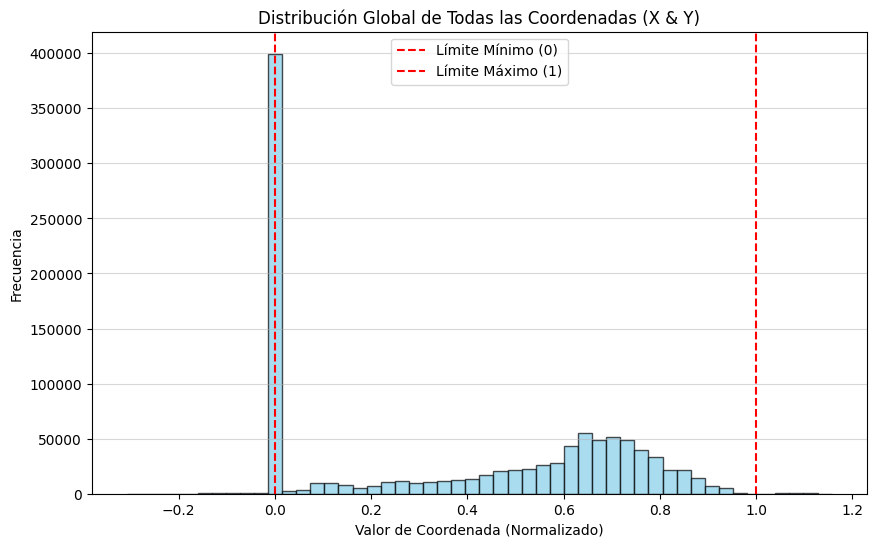

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que 'data_array' es tu numpy array de forma (50, 150, 66)
# data_array = np.load('tu_archivo.npy') 

# 1. Aplanar todos los datos de coordenadas
all_coords = np.concatenate((correct_push_ups, incorrect_push_ups)).flatten()

# 2. Configurar y graficar el histograma
plt.figure(figsize=(10, 6))
plt.hist(all_coords, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribución Global de Todas las Coordenadas (X & Y)')
plt.xlabel('Valor de Coordenada (Normalizado)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.5)
plt.axvline(x=0, color='r', linestyle='--', label='Límite Mínimo (0)')
plt.axvline(x=1, color='r', linestyle='--', label='Límite Máximo (1)')
plt.legend()
plt.show()

La herramienta de visión artificial MediaPipe Pose predice la posición de 33 puntos clave del cuerpo (x, y), tomando como origen la esquina inferior izquierda del frame. Cada vídeo tenía una longitud distinta originalmente, pero anteriormente añadimos paddings de 0s para que todas las secuencias tuvieran la misma longitud, lo que explica la gran cantidad de ceros observada en el histograma. En la arquitectura de red indicaremos que estos 0s son de padding con una capa Masking.

Por otro lado, algunos valores de las coordenadas superan 1 o son menores a 0. Esto ocurre cuando ciertos puntos clave quedan fuera del plano de la imagen. Estos datos pueden considerarse válidos, ya que únicamente representan posiciones fuera del marco visual y, siempre que mantengan coherencia geográfica con el resto del cuerpo, no deberían afectar negativamente al modelo de clasificación.


